## Notebook exploring the finetuning of Roberta

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

<a id='section03'></a>
### Preparing the Dataset and Dataloader


#### *ImdbData* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the Roberta model for training.

- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask` and `token_type_ids`. `max_len` which is the max token length can also be controlled and shorter sequences will be padded to this fixed length


#### Dataloader
- createDataLoaders calls the Dataset Class to create training and testing dataset before converting them into their respective dataloaders which are then used to load batches of data into the network where `batch_size` can be controlled



In [ ]:
class ImdbData(Dataset):
    def __init__(self,
                data_dir:str,
                is_train:bool,
                tokenizer:RobertaTokenizer,
                max_len:int):
        """
        Initializes an instance of the dataset class.Initializes the dataset by reading and tokenizing the data from the specified directory .

        Args:

        data_dir (str): The directory where the dataset is stored. It is used to load the data (either training or testing).
        is_train (bool): A flag indicating whether the dataset is for training (`True`) or testing (`False`).
        tokenizer (RobertaTokenizer): The tokenizer to process text data for the RoBERTa model, used to encode and convert raw text into tokens.
        max_len (int): The maximum sequence length after tokenization. Text will be padded or truncated to this length.
        """
        self.tokenizer = tokenizer
        self.data = self._read_imdb(data_dir, is_train)
        self.text = self.data.review
        self.targets = self.data.label
        self.max_len = max_len


    def __len__(self):
        return len(self.text)

    def _read_imdb(self,data_dir, is_train):
      data = []
      labels = []
      data_folder = 'train' if is_train else 'test'

      for label, label_folder in enumerate(['neg', 'pos']):
          # Retrieve full path
          full_path = os.path.join(data_dir, data_folder, label_folder)
          for text_file in os.listdir(full_path):
              # Read text
              with open(os.path.join(full_path, text_file), 'r', encoding='utf-8') as f:
                  # Add text and label
                  data.append(f.read())
                  labels.append(label)
      df=pd.DataFrame({'review': data, 'label': labels})
      df.head()
      return df

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
def createDataLoaders(data_dir:str,
                      tokenizer:RobertaTokenizer,
                      max_len:int,
                      train_batch_size:int,
                      test_batch_size:int):
  """
  Creates PyTorch DataLoaders for the training and testing datasets.

    Args:

        data_dir (str): The directory where the dataset is stored. It should contain training and testing data files.
        tokenizer (RobertaTokenizer): The tokenizer to process text data for the RoBERTa model, used to tokenize and encode the text.
        max_len (int): The maximum length for the tokenized sequences. Texts will be padded or truncated to this length.
        train_batch_size (int): The batch size for the training dataset.
        test_batch_size (int): The batch size for the testing dataset.

    Returns:

        train_loader (DataLoader): A DataLoader for the training dataset, providing batches of data.
        test_loader (DataLoader): A DataLoader for the testing dataset, providing batches of data.

    """
  training_set = ImdbData(data_dir,True, tokenizer, max_len)
  testing_set = ImdbData(data_dir,False, tokenizer, max_len)
  train_params = {'batch_size': train_batch_size,
                'shuffle': True,
                'num_workers': 0
                }

  test_params = {'batch_size': test_batch_size,
                'shuffle': False,
                'num_workers': 0
                }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  return training_loader,testing_loader

<a id='section04'></a>
### Model Architecture


 - We will be using the pretrained Roberta base model in  `RobertaClass`.
 - This network will have the Roberta Language model followed by pre_classifier layer (with Relu activation), a `dropout` layer and finally a `Linear` layer to obtain the final outputs.
 - Final layer output will be binary `label` which indicates whether the sentiment is positive or negative .


In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self,
                 dropout:float,
                 unfreeze_all:bool=False):
        """
        custom RoBERTa model class that extends `torch.nn.Module`.

        Args:

        dropout (float): The dropout rate to apply during training to prevent overfitting.
        This will be applied after the RoBERTa model layers.
        unfreeze_all (bool, optional):
        If `True`, all layers of the RoBERTa model will be unfrozen (made trainable) for fine-tuning.
        If `False`, only the last layers will be trainable, and the earlier layers will remain frozen. Default is `False`.
        """

        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(768, 2)

        if not unfreeze_all:
            for param in self.l1.parameters():
                param.requires_grad = False
        else:
            # Unfreeze all
            for param in self.l1.parameters():
                param.requires_grad = True


    def forward(self, input_ids, attention_mask, token_type_ids):
        #Pass inputs through the pre-trained RoBERTa model
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # Extract the [CLS] token's hidden state (the first token in the sequence).
        # This is often used as a summary representation of the entire sequence.
        hidden_state = output_1[0]    #[batch_size, seq_len, hidden_size]
        pooler = hidden_state[:, 0] #[batch_size, hidden_size]

        #pass through fully connected layer
        pooler = self.pre_classifier(pooler)
        #Apply ReLU activation to introduce non-linearity.
        pooler = torch.nn.ReLU()(pooler)
        #Apply dropout for regularization to reduce overfitting.
        pooler = self.dropout(pooler)#[batch_size, hidden_size]

        #Pass the result through the final classifier layer to get logits.
        #maps the hidden size to the number of output classes ie.2
        output = self.classifier(pooler) #[batch_size, num_classes]

        return output

### Training and evaluation



In [ ]:
def eval_model(model:RobertaClass,
               test_iter:DataLoader,
               device:torch.device,
               calc_confusion_matrix:bool=False,
               download_results:bool=False,
               result_path:str=None):

    """

    Function to evaluate model, returning the Accuracy, Precision, Recall and F1 score

    Args:
        model (RobertaClass): Instance of model
        test_iter (DataLoader): test dataloader
        device (torch.device): cpu or cuda
        calc_confusion_matrix (bool, Optional): Boolean if Precision, Recall and F1 score should also be calculated. Defaults to False.
        download_results (bool, Optional): Boolean to save predictions into a csv file. Defaults to False.
        result_path (str, Optional): CSV filepath for results

    Returns:
        accuracy, recall (None if calc_confusion_matrix == False), precision (None if calc_confusion_matrix == False), f1 (None if calc_confusion_matrix == False)

    """
    if download_results and result_path == None and '.csv' not in result_path:
        raise Exception("Invalid result filepath")

    prediction_list = []
    actual_list = []
    recall, precision, f1 = None, None, None
    
    # For download results
    sentence_list = []
    predicted_labels = []
    actual_labels = []
    tokenizer=RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

    # Setup model eval to prevent training
    model.eval()
    with torch.no_grad():
      for idx, data in tqdm(enumerate(test_iter), total=len(test_iter)):
          # Append actual scores
          actual_list.append(data['targets'].numpy())
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)


          outputs = model(ids, mask, token_type_ids)
          # Append predicted scores

          predicted = torch.argmax(outputs, dim=-1)
          prediction_list.append(predicted.cpu().numpy())
          # Append results
          if download_results:
            sentence_list.extend(tokenizer.batch_decode(data['ids'], skip_special_tokens=True))
            # Labels
            predicted_labels.extend(["negative" if pred == 0 else "positive" for pred in predicted.cpu().numpy()])
            actual_labels.extend(["negative" if pred == 0 else "positive" for pred in data['targets'].cpu().numpy()])

    # Flatten the lists into arrays
    actual_list = np.concatenate(actual_list)
    prediction_list = np.concatenate(prediction_list)

    # Calculate accuracy
    accuracy = accuracy_score(actual_list, prediction_list)

    # Calculate other metrics
    if calc_confusion_matrix:
        recall = recall_score(actual_list, prediction_list)
        precision = precision_score(actual_list, prediction_list)
        f1 = f1_score(actual_list, prediction_list)
    
    # Download results
    if download_results:
        data = pd.DataFrame({
            'Sentence': sentence_list,
            'Actual': actual_labels,
            "Predicted": predicted_labels
        })

        data.to_csv(result_path, index=False)

    return accuracy, recall, precision, f1

In [ ]:
def train_model(model:RobertaClass,
                train_iter:DataLoader,
                test_iter:DataLoader,
                num_epochs:int,
                learning_rate:float,
                device:torch.device,
                show_training_graph:bool,
                best_model_path:str,
                final_model_path:str):

    """
    Function to train and evaluate model
    The model will train on the train_iter, be evaluated on test_iter
    Best model with highest accuracy on test_iter will be saved in best_model_path
    Final model after last epoch will be saved in final_model_path

    Args:
        model (RobertaClass): model to be trained
        train_iter (DataLoader): train dataset
        test_iter (DataLoader): test dataset
        num_epochs (int): Number of epochs to train
        learning_rate(float)
        device (torch.device): cuda or cpu
        show_training_graph (bool): boolean to show the training loss, training acc and test acc graph across epochs
        best_model_path (str): path to best model
        final_model_path (str): path to model aft final epoch training
    """
    train_loss_container = []
    train_acc_container = []
    test_acc_container = []

    best_test_acc = 0
    loss_function = torch.nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(params = model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        # Setup training
        model.train()
        model.to(device)

        for idx, data in tqdm(enumerate(train_iter), total=len(train_iter)):

            # ids, mask, token_type_ids, targets = data['ids'].to(device), data['mask'].to(device), data['token_type_ids'].to(device), data['targets'].to(device)
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            # Get predictions and loss
            outputs = model(ids, mask, token_type_ids)

            loss = loss_function(outputs, targets)

            total_train_loss += loss.item()

            # Train
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Count accuracy
            predicted = torch.argmax(outputs, dim=-1)
            total_train_correct += (predicted == targets).sum().item()
            total_train_samples += targets.shape[0]

        # Evaluation for test
        test_acc, _, _, _ = eval_model(model, test_iter, device)

        train_loss_container.append(total_train_loss/len(train_iter)) #total num of batches
        train_acc_container.append(total_train_correct/total_train_samples)
        test_acc_container.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model, best_model_path)
            print(f"Best Model Saved at epoch {epoch+1}")

        print(f"Epoch {epoch+1} completed, train_loss: {total_train_loss/len(train_iter)}, train_acc: {total_train_correct/total_train_samples}, test_acc: {test_acc}")

    # Save Final model
    torch.save(model, final_model_path)

    if show_training_graph:
        # Graph with matplotlib
        # Plot each list
        plt.plot(train_loss_container, label='Train Loss', color='blue')
        plt.plot(train_acc_container, label='Train Acc', color='green')
        plt.plot(test_acc_container, label='Test Acc', color='red')

        # Add labels and legend
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

In [ ]:
def run(dropout:float,
        data_dir:str,
        tokenizer:RobertaTokenizer,
        max_len:int,
        train_batch_size:int,
        test_batch_size:int,
        num_epochs:int,
        learning_rate:float,
        device:torch.device,
        unfreeze_all:bool=False):
      """
      Trains and evaluates a RoBERTa-based model on the specified dataset.

      Args:
            dropout (float): The dropout rate to use during training to prevent overfitting.
            data_dir (str): The directory containing the dataset (either training or testing data).
            tokenizer (RobertaTokenizer): The tokenizer used to tokenize input text for RoBERTa.
            max_len (int): The maximum sequence length for tokenizing the input text.
            train_batch_size (int): The batch size to use during the training phase.
            test_batch_size (int): The batch size to use during the testing/validation phase.
            num_epochs (int): The number of epochs to train the model.
            learning_rate (float): The learning rate for the optimizer.
            device (torch.device): The device (either 'cpu' or 'cuda') where the model and data will be moved for training.
            unfreeze_all (bool, optional): Whether to unfreeze all layers of the model for training. Default is False."""

      model = RobertaClass(dropout,unfreeze_all)
      model.to(device)

      train_iter,test_iter= createDataLoaders(data_dir,tokenizer,max_len,train_batch_size,test_batch_size)

      train_model(model,
                  train_iter,
                  test_iter,
                  num_epochs,
                  learning_rate,
                  device,
                  True,
                  best_model_path=f"../models/best_dropout_{dropout}_tokenlen_{max_len}_bs_{train_batch_size}_lr_{learning_rate}.pt",
                  final_model_path=f"../models/final_dropout_{dropout}_tokenlen_{max_len}_bs_{train_batch_size}_lr_{learning_rate}.pt",
                  )

### Execution

In [ ]:
data_dir = "../data/aclImdb"
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:09<00:00,  4.13it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6882944424134081, train_acc: 0.55708, test_acc: 0.73808


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:08<00:00,  4.14it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.6765225281953202, train_acc: 0.66892, test_acc: 0.76448


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:08<00:00,  4.14it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.6627483257399801, train_acc: 0.72144, test_acc: 0.78052


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:09<00:00,  4.12it/s]


Epoch 4 completed, train_loss: 0.6474839471795065, train_acc: 0.7506, test_acc: 0.77948


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:09<00:00,  4.13it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.6306428371945305, train_acc: 0.76204, test_acc: 0.79488


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:07<00:00,  4.18it/s]


Epoch 6 completed, train_loss: 0.612570878108749, train_acc: 0.77068, test_acc: 0.79004


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:08<00:00,  4.16it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.5956261971265154, train_acc: 0.77552, test_acc: 0.79892


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:19<00:00,  3.92it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.578790409943027, train_acc: 0.78008, test_acc: 0.8012


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:10<00:00,  4.11it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.5649239952149598, train_acc: 0.78276, test_acc: 0.80364


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:20<00:00,  3.91it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.5519717122282823, train_acc: 0.7874, test_acc: 0.80508


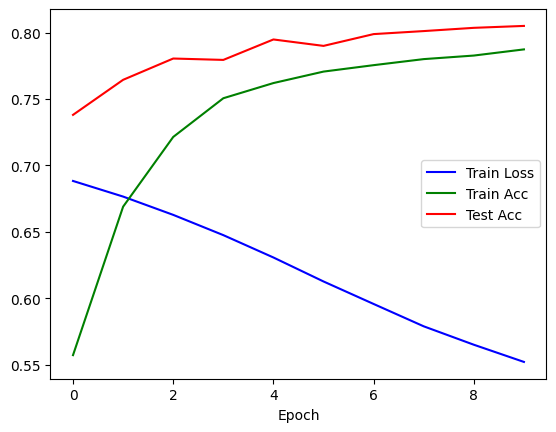

In [ ]:
run(dropout=0.1,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=128,
    train_batch_size=32,
    test_batch_size=32,
    num_epochs=10,
    learning_rate=1e-5,
    device=device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/782 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_

Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6898070874878818, train_acc: 0.53924, test_acc: 0.75972


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:09<00:00,  4.12it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.6796837557307289, train_acc: 0.60112, test_acc: 0.77368


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:08<00:00,  4.14it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.6679521694665065, train_acc: 0.66204, test_acc: 0.78588


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:08<00:00,  4.15it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.6551033343043169, train_acc: 0.7034, test_acc: 0.79064


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 782/782 [03:08<00:00,  4.16it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.6409138500538019, train_acc: 0.73104, test_acc: 0.7932


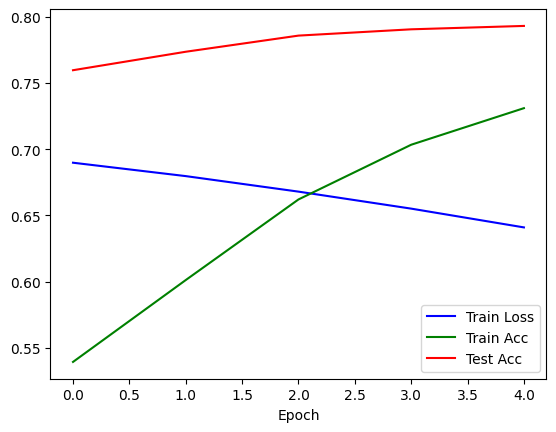

In [ ]:
run(dropout=0.3,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=128,
    train_batch_size=32,
    test_batch_size=32,
    num_epochs=5,
    learning_rate=1e-5,
    device=device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 3125/3125 [03:13<00:00, 16.14it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6841810778427124, train_acc: 0.5764, test_acc: 0.76816


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:13<00:00, 16.15it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.6595574473762512, train_acc: 0.68396, test_acc: 0.77128


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:13<00:00, 16.18it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.6307533973789216, train_acc: 0.7382, test_acc: 0.78136


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:13<00:00, 16.15it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.5995527732372284, train_acc: 0.76796, test_acc: 0.79856


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:13<00:00, 16.13it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.5709615029430389, train_acc: 0.77328, test_acc: 0.79996


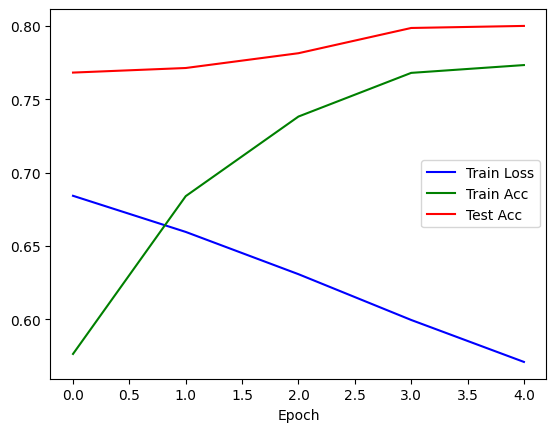

In [ ]:
run(dropout=0.3,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=128,
    train_batch_size=8,
    test_batch_size=8,
    num_epochs=5,
    learning_rate=1e-5,
    device=device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 391/391 [03:15<00:00,  1.99it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6924825615590186, train_acc: 0.52288, test_acc: 0.717


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 391/391 [03:15<00:00,  2.00it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.6835922470787907, train_acc: 0.57556, test_acc: 0.72728


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 391/391 [03:15<00:00,  2.00it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.6759123032355248, train_acc: 0.62508, test_acc: 0.7806


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 391/391 [03:15<00:00,  2.00it/s]


Epoch 4 completed, train_loss: 0.6670396164859957, train_acc: 0.66864, test_acc: 0.77812


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 391/391 [03:15<00:00,  2.00it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.6578453577997739, train_acc: 0.69568, test_acc: 0.78692


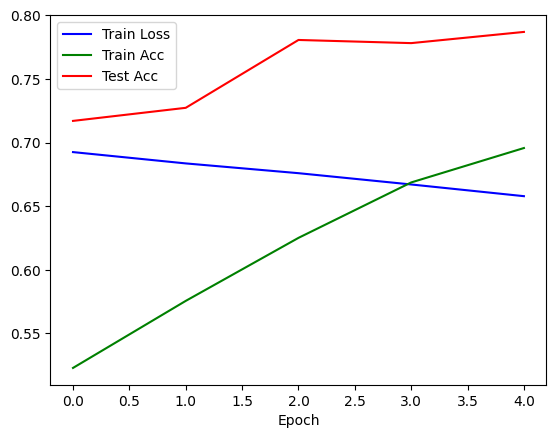

In [ ]:
run(dropout=0.3,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=128,
    train_batch_size=64,
    test_batch_size=64,
    num_epochs=5,
    learning_rate=1e-5,
    device=device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:11<00:00,  8.42it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.2328459622082114, train_acc: 0.9058, test_acc: 0.93572


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:11<00:00,  8.42it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.1410691777882725, train_acc: 0.94932, test_acc: 0.93896


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:11<00:00,  8.42it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.09242937191616744, train_acc: 0.968, test_acc: 0.94032


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:13<00:00,  8.37it/s]


Epoch 4 completed, train_loss: 0.06066451748425141, train_acc: 0.98084, test_acc: 0.9334


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:11<00:00,  8.41it/s]


Epoch 5 completed, train_loss: 0.03992470948194154, train_acc: 0.9874, test_acc: 0.93792


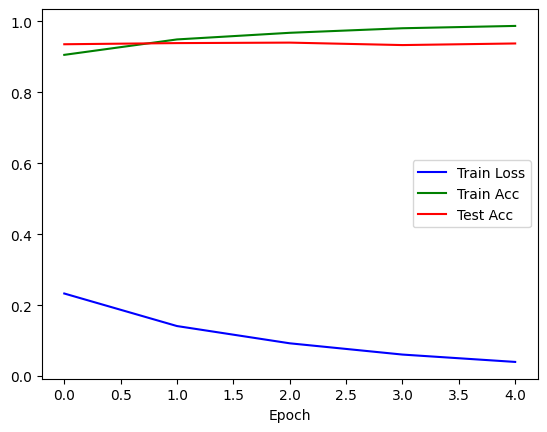

In [ ]:
run(dropout=0.3,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=256,
    train_batch_size=8,
    test_batch_size=8,
    num_epochs=5,
    learning_rate=1e-5,
    device=device,
    unfreeze_all=True)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3125 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max

Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.26188682737633584, train_acc: 0.89752, test_acc: 0.92296


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:12<00:00,  8.38it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.1709756749097258, train_acc: 0.9366, test_acc: 0.92748


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:13<00:00,  8.37it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.12397155315864831, train_acc: 0.95656, test_acc: 0.9322


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:13<00:00,  8.37it/s]


Epoch 4 completed, train_loss: 0.08815310962937772, train_acc: 0.96932, test_acc: 0.9244


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [06:14<00:00,  8.35it/s]


Epoch 5 completed, train_loss: 0.07163566191539168, train_acc: 0.97664, test_acc: 0.92308


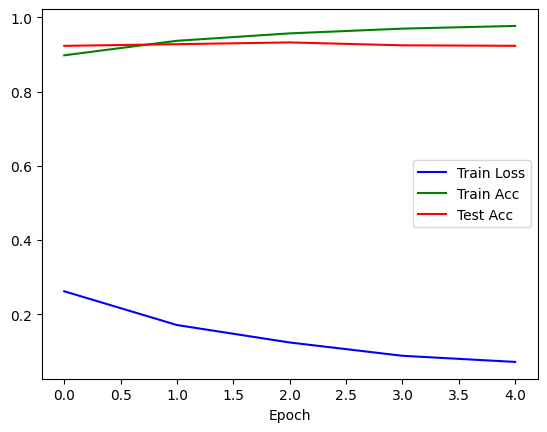

In [ ]:
run(dropout=0.3,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=256,
    train_batch_size=8,
    test_batch_size=8,
    num_epochs=5,
    learning_rate=3e-5,
    device=device,
    unfreeze_all=True)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3125 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max

Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.23399929959535598, train_acc: 0.90356, test_acc: 0.932


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [05:58<00:00,  8.72it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.14621165393702687, train_acc: 0.94652, test_acc: 0.93364


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [05:58<00:00,  8.72it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.09444121253807097, train_acc: 0.96744, test_acc: 0.93772


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [05:58<00:00,  8.71it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.06346920679150149, train_acc: 0.97904, test_acc: 0.93936


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [05:58<00:00,  8.71it/s]


Epoch 5 completed, train_loss: 0.04485181882185862, train_acc: 0.98516, test_acc: 0.93588


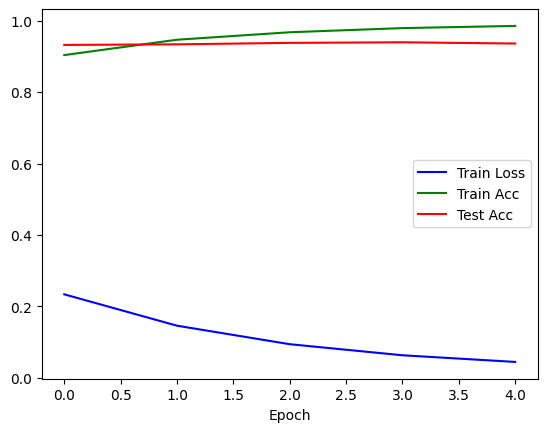

In [ ]:
run(dropout=0.4,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=256,
    train_batch_size=8,
    test_batch_size=8,
    num_epochs=5,
    learning_rate=1e-5,
    device=device,
    unfreeze_all=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:11<00:00, 16.36it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.29519724658459423, train_acc: 0.87164, test_acc: 0.90128


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:11<00:00, 16.34it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.19863656882122158, train_acc: 0.92296, test_acc: 0.90448


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:11<00:00, 16.31it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.14030622543007135, train_acc: 0.94756, test_acc: 0.90544


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:11<00:00, 16.33it/s]


Epoch 4 completed, train_loss: 0.09495007202856243, train_acc: 0.96572, test_acc: 0.903


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3125/3125 [03:11<00:00, 16.30it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.06847884873798117, train_acc: 0.97672, test_acc: 0.90716


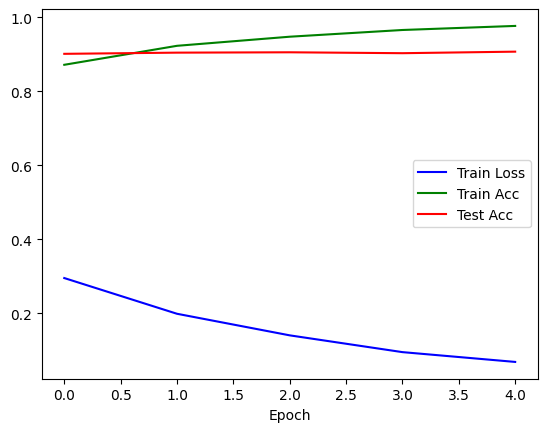

In [ ]:
run(dropout=0.4,
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_len=128,
    train_batch_size=8,
    test_batch_size=8,
    num_epochs=5,
    learning_rate=1e-5,
    device=device,
    unfreeze_all=True)

### Evaluation on Released Test dataset
Since the test data is a csv, we will have to modify the _read_data function in the dataset

In [4]:
class TestIMDBDataset(Dataset):
    def __init__(self,
                 csv_path: str,
                 tokenizer:RobertaTokenizer,
                  max_len:int):
        """
        Test Dataset Class
        The dataset will be created by reading all documents inside the file,
        to which they will be preprocessed.

        Args:
            csv_path (str): path to CSV file
            tokenizer (RobertaTokenizer): The tokenizer to process text data for the RoBERTa model, used to encode and convert raw text into tokens.
            max_len (int): The maximum sequence length after tokenization. Text will be padded or truncated to this length.
        """
        self.text, self.targets = self._read_data(csv_path)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def _read_data(self, csv_path):
        dataset = pd.read_csv(csv_path)
        data = dataset['text']
        labels = dataset['label']
        return data, labels

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
def runTest(modelfile:str,
            csv_path:str,
            tokenizer:RobertaTokenizer,
            max_len:int,
            test_batch_size:int,
            device:torch.device,
            calc_confusion_matrix:bool=False,
            download_results:bool=False,
            result_path:str=None ):


    testing_set = TestIMDBDataset(csv_path, tokenizer, max_len)

    test_params = {'batch_size': test_batch_size,
                    'shuffle': False,
                    'num_workers': 0
                    }
    test_iter = DataLoader(testing_set, **test_params)

    # Load model
    model=torch.load(modelfile,weights_only=False)
    
    # Eval model
    accuracy, recall, precision, f1=eval_model(model,
                test_iter,
                device,
                None,
                calc_confusion_matrix,
                download_results,
                result_path)
    print(accuracy, recall, precision, f1)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path="../data/test_data_movie.csv"
result_dir = "../results/"

In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,freeze roberta
#0.1,128,32,1e-5,10,F

modelfile="../models/best_dropout_0.1_tokenlen_128_bs_32_lr_1e-05.pt"
max_len=128
test_batch_size=32
result_path=result_dir+"results1.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,#set this to true if want saved prediction results to csv
        result_path)

  0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1250/1250 [05:21<00:00,  3.89it/s]

0.80805 0.8291877283419248 0.7952767244275908 0.8118782770617925


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,freeze roberta
#0.3,128,32,1e-5,5,F



modelfile="../models/best_dropout_0.3_tokenlen_128_bs_32_lr_1e-05.pt"
max_len=128
test_batch_size=32
result_path=result_dir+"results2.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,
        result_path)

  0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1250/1250 [05:15<00:00,  3.96it/s]

0.794925 0.8233321655572794 0.7787824275705358 0.8004379029315168


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,freeze roberta
#0.3, 128, 8, 1e-5, 5, F

modelfile="../models/best_dropout_0.3_tokenlen_128_bs_8_lr_1e-05.pt"
max_len=128
test_batch_size=8
result_path=result_dir+"results3.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,
        result_path)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5000/5000 [05:19<00:00, 15.65it/s]


0.8025 0.8580151143586408 0.7720088260458414 0.812742960083436


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,freeze roberta
#0.3, 128, 64, 1e-5, 5, F

modelfile="../models/best_dropout_0.3_tokenlen_128_bs_64_lr_1e-05.pt"
max_len=128
test_batch_size=64
result_path=result_dir+"results4.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,
        result_path)

  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 625/625 [05:22<00:00,  1.94it/s]

0.78975 0.7619738751814223 0.8064516129032258 0.7835820895522388


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,Unfreeze roberta
#0.3, 256, 8, 1e-5, 5, T

modelfile="../models/best_dropout_0.3_tokenlen_256_bs_8_lr_1e-05.pt"
max_len=256
test_batch_size=8
result_path=result_dir+"results5.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,
        result_path)

  0%|          | 0/5000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5000/5000 [10:24<00:00,  8.01it/s]


0.950725 0.9566588258845904 0.945351137487636 0.9509713688714211


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,Unfreeze roberta
#0.3, 256, 8, 3e-5, 5, T

modelfile="../models/best_dropout_0.3_tokenlen_256_bs_8_lr_3e-05.pt"
max_len=256
test_batch_size=8
result_path=result_dir+"results6.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,
        result_path)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5000/5000 [10:29<00:00,  7.94it/s]


0.9595 0.9609128672238627 0.9581316432955737 0.95952023988006


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,Unfreeze roberta
#0.4, 256, 8, 1e-5, 5, T

modelfile="../models/best_dropout_0.4_tokenlen_256_bs_8_lr_1e-05.pt"
max_len=256
test_batch_size=8
result_path=result_dir+"results7.csv"

# Best model, saving results
runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        True, # Save results
        result_path)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5000/5000 [10:15<00:00,  8.13it/s]


0.9673 0.9703718532605976 0.964386968415817 0.9673701541685377


In [ ]:
#Dropout,Max token length,Batch Size,Learning rate,Epochs,Unfreeze roberta
#0.4, 128, 8, 1e-5, 5, T

modelfile="../models/best_dropout_0.4_tokenlen_128_bs_8_lr_1e-05.pt"
max_len=128
test_batch_size=8
result_path=result_dir+"results8.csv"

runTest(modelfile,
        csv_path,
        tokenizer,
        max_len,
        test_batch_size,
        device,
        True,
        False,
        result_path)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5000/5000 [05:23<00:00, 15.44it/s]


0.950975 0.9583103948751314 0.9443677253896232 0.9512879747621532
